# Data Loading

In [ ]:
import io
import os
import re
import tqdm
import warnings
import itertools
from ast import literal_eval

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from string import punctuation

import nltk
import sklearn
from sklearn import decomposition
from sklearn.utils import class_weight
from nltk.tokenize import word_tokenize
import tensorflow as tf

nltk.download("punkt")
nltk.download('wordnet')
nltk.download('stopwords')
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
tqdm.tqdm_notebook()
tqdm.notebook.tqdm().pandas()

### Data collection and preprocessing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
filepath = "/content/drive/MyDrive/NLP_Capgemini_2021/NLP @ X_HEC - 2K21/Cours 4 - Embedding part 2/data/clean_text_scrapped_data_2021.csv.gz"

DATASET_SIZE = 10000
def get_reviews(nrows=None):
    return pd.read_csv(filepath,
                     compression='gzip', 
                     low_memory=False, 
                     nrows=nrows,
                     parse_dates=['diner_date', 'rating_date'])
    
def remove_stops(review):
    stop_words = nltk.corpus.stopwords.words('english')
    tokens = word_tokenize(review)
    return [i for i in tokens if not i in stop_words]

def clean_reviews(reviews):
    reviews['review'] = reviews.content.apply(lambda x: ' '.join(eval(x)))
    reviews['review'] = reviews['review'].apply(lambda x: ' '.join(remove_stops(x)))
    return reviews

def split_reviews_per_sentence(reviews):
    reviews["review_sentences"] = reviews.review.progress_apply(
        lambda rvw: nltk.sent_tokenize(rvw)
    )
    return reviews

In [ ]:
reviews = get_reviews(DATASET_SIZE)
reviews.head(2)

,Unnamed: 0,0,answer_text,content,diner_date,id_comment,id_resto,other_ratings_category,other_ratings_value,rating,rating_date,resto,resto_url,reviewer_info_sup,reviewer_origin,reviewer_pseudo,title,url,Day_of_week,clean_content
0,482202,NaN,['We are extreamly sad about your Experiance. ...,['We actually visited this place a few times f...,2017-01-01,g10259438-d11744624-r450260275,g10259438-d11744624,[],[],1.0,2017-01-07,Buns_E17,/Restaurant_Review-g10259438-d11744624-Reviews...,"[['pencil-paper', '11'], ['thumbs-up', '4']]","['London, United Kingdom']",lubix0209,Really disappointing,https://www.tripadvisor.com/ShowUserReviews-g1...,5,"[""'we"", 'actually', 'visited', 'place', 'time'..."
1,482231,NaN,"['Hey gucci Burger', 'Thank you so much for th...",['A blast of warm air greeted us as we entered...,2019-01-01,g10259438-d11744624-r645208007,g10259438-d11744624,[],[],5.0,2019-01-11,Buns_E17,/Restaurant_Review-g10259438-d11744624-Reviews...,"[['pencil-paper', '5'], ['thumbs-up', '1']]","['Chingford, United Kingdom']",Depeche242,Gucci Burgers,https://www.tripadvisor.com/ShowUserReviews-g1...,4,"['blast', 'warm', 'air', 'greeted', 'u', 'ente..."


### Preprocessing & Understanding

In [ ]:
reviews = clean_reviews(reviews)
reviews = split_reviews_per_sentence(reviews)

In [ ]:
reviews.head()

,Unnamed: 0,0,answer_text,content,diner_date,id_comment,id_resto,other_ratings_category,other_ratings_value,rating,rating_date,resto,resto_url,reviewer_info_sup,reviewer_origin,reviewer_pseudo,title,url,Day_of_week,clean_content,review,review_sentences
0,482202,NaN,['We are extreamly sad about your Experiance. ...,['We actually visited this place a few times f...,2017-01-01,g10259438-d11744624-r450260275,g10259438-d11744624,[],[],1.0,2017-01-07,Buns_E17,/Restaurant_Review-g10259438-d11744624-Reviews...,"[['pencil-paper', '11'], ['thumbs-up', '4']]","['London, United Kingdom']",lubix0209,Really disappointing,https://www.tripadvisor.com/ShowUserReviews-g1...,5,"[""'we"", 'actually', 'visited', 'place', 'time'...",We actually visited place times lunch since op...,[We actually visited place times lunch since o...
1,482231,NaN,"['Hey gucci Burger', 'Thank you so much for th...",['A blast of warm air greeted us as we entered...,2019-01-01,g10259438-d11744624-r645208007,g10259438-d11744624,[],[],5.0,2019-01-11,Buns_E17,/Restaurant_Review-g10259438-d11744624-Reviews...,"[['pencil-paper', '5'], ['thumbs-up', '1']]","['Chingford, United Kingdom']",Depeche242,Gucci Burgers,https://www.tripadvisor.com/ShowUserReviews-g1...,4,"['blast', 'warm', 'air', 'greeted', 'u', 'ente...","A blast warm air greeted us entered , Basic se...","[A blast warm air greeted us entered , Basic s..."
2,890629,NaN,"['oh dear, ', 'sounds like you had a bad time ...","['Been here a few times now, the chai is all I...",2018-08-01,g10259438-d12901207-r602428399,g10259438-d12901207,[],[],3.0,2018-08-03,Chaiiwala,/Restaurant_Review-g10259438-d12901207-Reviews...,"[['pencil-paper', '12']]","['Walthamstow, United Kingdom']",653izz,"Great Chai, Food is Ok",https://www.tripadvisor.com/ShowUserReviews-g1...,4,"[""'been"", 'time', 'now', 'chai', 'go', 'tried'...","Been times , chai I go , I tried options menu ...","[Been times , chai I go , I tried options menu..."
3,890611,NaN,"['Hi there,', 'please get in touch with more i...",['chaiiwala in Peterborough is the best I neve...,2018-12-01,g10259438-d12901207-r638063634,g10259438-d12901207,"['Value', 'Service', 'Food']","['10', '10', '10']",1.0,2018-12-07,Chaiiwala,/Restaurant_Review-g10259438-d12901207-Reviews...,"[['pencil-paper', '1']]",[],mehr4nkh4n,chaiiwala in Peterborough,https://www.tripadvisor.com/ShowUserReviews-g1...,4,"[""'chaiiwala"", 'peterborough', 'best', 'never'...",chaiiwala Peterborough best I never bad ras ma...,[chaiiwala Peterborough best I never bad ras m...
4,890612,NaN,"['Hi Shoque31,', 'so sorry to disappoint you w...",['My wife had been raving about this place. He...,2018-12-01,g10259438-d12901207-r639632292,g10259438-d12901207,[],[],2.0,2018-12-14,Chaiiwala,/Restaurant_Review-g10259438-d12901207-Reviews...,"[['pencil-paper', '112'], ['thumbs-up', '41']]","['London, United Kingdom']",shoque31,One off,https://www.tripadvisor.com/ShowUserReviews-g1...,4,"[""'my"", 'wife', 'raving', 'place', 'friend', '...",My wife raving place . Her friend told . So we...,"[My wife raving place ., Her friend told ., So..."


In [ ]:
first_reviews = reviews.head(10000)
first_reviews.shape

(10000, 22)

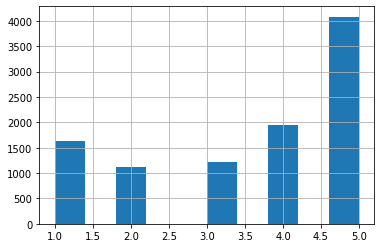

In [ ]:
first_reviews["rating"].hist() 

In [ ]:
first_reviews["rating"].value_counts() / len(first_reviews)

5.0    0.4081
4.0    0.1946
1.0    0.1640
3.0    0.1215
2.0    0.1118
Name: rating, dtype: float64

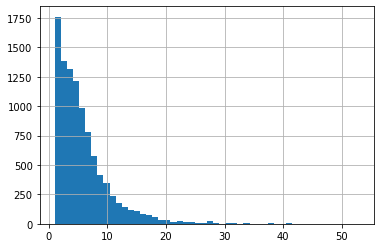

In [ ]:
first_reviews["review_sentences"].apply(len).hist(bins=50) ### FILL THE BLANK ###

In [ ]:
sentences = list(itertools.chain(*first_reviews["review_sentences"]))
print(f"Number of total sentences : {len(sentences)}")

Number of total sentences : 60624


### Tokenization & Text Encoding
This part concerns tokenization and text encoding with TensorFlow modules :

*(i) Build the token vocabulary* <br>
*(ii) Build a text encoder relying each word to an index, and thus each text to a sequence of word indices* (```list```) <br>
*(iii) Build a TensorFlow dataset for word2vec training*



In [ ]:
# Define and fit tokenizer
tokenizer = tf.keras.preprocessing.text.Tokenizer(filters=' ', char_level=False)
tokenizer.fit_on_texts(sentences)

In [ ]:
sequences = tokenizer.texts_to_sequences(sentences) 
print(first_reviews["review_sentences"][0][0], sentences[0], sequences[0], sep="\n\n")

We actually visited place times lunch since opened fine .

We actually visited place times lunch since opened fine .

[7, 418, 63, 29, 114, 39, 293, 813, 273, 1]


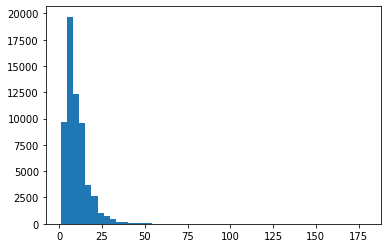

In [ ]:
# Check the distribution of the number of indices per sequence
plt.hist([len(sequence) for sequence in sequences], bins=50); ### FILL THE BLANK ###
plt.show()

# 1. Train our own word embeddings 

## Negative Sampling Skipgram
Preprocessing function which generates skip-gram pairs with negative sampling for a list of sequences (int-encoded sentences) based on window size, number of negative samples and (tokenizer) vocabulary size.

In [ ]:
max(tokenizer.index_word.keys())

20708

## Generate training data for word2vec

*(i) Define a sampling table for words in vocabulary, see [make_sampling_table](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/make_sampling_table)* <br>
*(ii) For each sequence (tokenized/indexed sentence), run sliding process (window) and appropriate word sampling to build positive skip-gram word pairs* <br>
*(iii) Iterate over each positive skip-gram pair to produce training examples with positive context word and negative samples, building corresponding labels.* <br>
*(iv) Returns overall combinations of (target word, context word, negative words)*

In [ ]:
def generate_training_data(sequences, window_size, num_ns, vocab_size, seed=42):
    # Elements of each training example are appended to these lists.
    targets, contexts, labels = [], [], []

    # Build the sampling table for vocab_size tokens.
    sampling_table = tf.keras.preprocessing.sequence.make_sampling_table(vocab_size)

    # Iterate over all sequences (sentences) in dataset.
    for sequence in tqdm.notebook.tqdm(sequences):

        # Generate positive skip-gram pairs for a sequence (sentence).
        positive_skip_grams, _ = tf.keras.preprocessing.sequence.skipgrams(
            sequence, 
            vocabulary_size=vocab_size,
            sampling_table=sampling_table,
            window_size=window_size,
            negative_samples=0
        )

        # Iterate over each positive skip-gram pair to produce training examples 
        # with positive context word and negative samples.
        for target_word, context_word in positive_skip_grams:
            context_class = tf.expand_dims(tf.constant([context_word], dtype="int64"), 1)
            negative_sampling_candidates, _, _ = tf.random.log_uniform_candidate_sampler(
                true_classes=context_class,
                num_true=1, 
                num_sampled=num_ns, 
                unique=True, 
                range_max=vocab_size, 
                seed=seed, 
                name="negative_sampling"
            )

            # Build context and label vectors (for one target word)
            negative_sampling_candidates = tf.expand_dims(negative_sampling_candidates, 1)

            context = tf.concat([context_class, negative_sampling_candidates], 0)
            label = tf.constant([1] + [0]*num_ns, dtype="int64")

            # Append each element from the training example to global lists.
            targets.append(target_word)
            contexts.append(context)
            labels.append(label)

    return targets, contexts, labels

**Question** : Build training data using ```window_size=2``` and number of negative samples per positive pair ```num_ns=4```. 

In [ ]:
targets, contexts, labels = generate_training_data(
    sequences=sequences, 
    window_size=2, 
    num_ns=4, 
    vocab_size=max(tokenizer.index_word.keys())+1 # vocab size + 1 for padding
)

print(len(targets), len(contexts), len(labels))


372260 372260 372260


In [ ]:
targets[0], contexts[0]

(63, <tf.Tensor: shape=(5, 1), dtype=int64, numpy=
 array([[   7],
        [ 464],
        [  35],
        [3060],
        [ 126]])>)

## Define TensorFlow dataset
Define valid TensorFlow dataset from targets/contexts/labels iterable objects.
Set two parameters : 
* *BUFFER_SIZE*
* *BATCH_SIZE*

*BATCH_SIZE* can be particularly important for making training efficient. Note that *BATCH_SIZE* must be obviously lower than dataset size.

In [ ]:
BATCH_SIZE = 512
BUFFER_SIZE = 10000

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices(((targets, contexts), labels))
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
print(dataset)

<BatchDataset shapes: (((512,), (512, 5, 1)), (512, 5)), types: ((tf.int32, tf.int64), tf.int64)>


Define Skipgram model

In [ ]:
class Skipgram(tf.keras.Model):
    """Negative Sampling Skigpram implementation.

    ```python
    w2v = Skipgram(vocab_size=4096, embedding_dim=128)
    ````
    """
    def __init__(self, vocab_size, embedding_dim):
        """Skigpram class constructor.

        Parameters
        ----------
        vocab_size: int.
            Size of the vocabulary.

        embedding_dim: int.
            Dimension of trained word2vec Skipgram embeddings.

        """
        super(Skipgram, self).__init__()
        self.target_embedding = tf.keras.layers.Embedding(
            vocab_size, 
            embedding_dim,
            input_length=1,
            name="w2v_embedding",
        )
        self.context_embedding = tf.keras.layers.Embedding(
            vocab_size, 
            embedding_dim, 
            input_length=4+1, # number of negative samples = 4
            name="context_embedding",
        ) 
        self.dots = tf.keras.layers.Dot(axes=(3,2))
        self.flatten = tf.keras.layers.Flatten()

    def call(self, pair):
        """Model forward method.
        """
        target, context = pair
        we = self.target_embedding(target)
        ce = self.context_embedding(context)
        dots = self.dots([ce, we])
        
        return self.flatten(dots)

Define objective and training

In [ ]:
embedding_dim = 128

word2vec = Skipgram(vocab_size=max(tokenizer.index_word.keys())+1, embedding_dim=128)
word2vec.compile(
    optimizer="adam",
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

In [ ]:
#word2vec.fit(dataset, epochs=20)

## Word Embeddings

word2vec.summary()

In [ ]:
#tf.keras.models.save_model(word2vec,'/content/drive/MyDrive/NLP_Capgemini_2021/NLP @ X_HEC - 2K21/Cours 4 - Embedding part 2/data/')

In [ ]:
word2vec = tf.keras.models.load_model('/content/drive/MyDrive/NLP_Capgemini_2021/NLP @ X_HEC - 2K21/Cours 4 - Embedding part 2/data/')

In [ ]:
pretrained_weights = word2vec.get_layer('w2v_embedding').get_weights()[0]
pretrained_weights.shape

(20709, 128)

In [ ]:
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

for idx, word in tokenizer.index_word.items():
    
    vec = pretrained_weights[idx] # first idx is 1 : skip 0, it's padding.
    out_m.write(word + "\n")
    out_v.write('\t'.join([str(x) for x in vec]) + "\n")
    
out_v.close()
out_m.close()

## 2. Train a sentiment model 
### Using your pre trained embeddings train a simple rating Classifier

Our learned word embeddings can be used to represent the words of a text and to build a text representation. This text representation will be useful for classifcation.


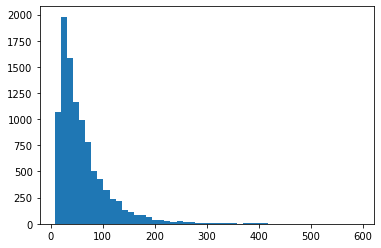

In [ ]:
processed_review = [' '.join(rvw) for rvw in first_reviews["review_sentences"]] ### FILL THE BLANK ###
processed_sequences = tokenizer.texts_to_sequences(processed_review)

plt.hist([len(sequence) for sequence in processed_sequences], bins=50)
plt.show()

In [ ]:
padded_processed_sequences = tf.keras.preprocessing.sequence.pad_sequences(processed_sequences, maxlen=180, padding="post")
padded_processed_sequences.shape

(10000, 180)

In [ ]:
first_reviews.rating.value_counts()

5.0    4081
4.0    1946
1.0    1640
3.0    1215
2.0    1118
Name: rating, dtype: int64

In [ ]:
first_reviews['usable_rating'] = first_reviews['rating'].apply(lambda r: int(r)-1)
first_reviews.usable_rating.value_counts()

4    4081
3    1946
0    1640
2    1215
1    1118
Name: usable_rating, dtype: int64

Build datasets

In [ ]:
rating_labels = tf.keras.utils.to_categorical(first_reviews['usable_rating'], num_classes=5, dtype='float32')
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(padded_processed_sequences, rating_labels, test_size=0.3)

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))

train_ds = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
test_ds = test_ds.batch(BATCH_SIZE)


## 3.Hierarchical Attention Network (HAN) with dropout and regularization

<img src="https://drive.google.com/uc?id=1Q4H1MlBZ6ZasBCHxlARc25T9mBFRctiy"/>
<ID of image>


Preprocessing

For Hierarchical Attention Network, text preprocessing and inputs differ from the previous method. Here, the input is not just a sequence of all integers corresponding to all words/tokens of the review. Working at a sentence-level, the HAN input is a sequence of sequences (tokenized sentences) of integers. 

Thus, a such architecture needs a particular preprocessing (padding and truncating).

In [ ]:
def review_preprocessing(review, words_maxlen=50, sentences_maxlen=10, tokenizer=tokenizer):
    """Preprocessing function to build appropriate padded sequences for HAN.

    Parameters
    ----------
    review: list.
        List of sentences (strings) of the review.
    
    words_maxlen: int.
        Maximal length/number of words for a sentence.

    sentences_maxlen: int.
        Maximal length/number of sentences for a review.

    Returns
    -------
    padded_sequences: tf.Tensor.
        Tensor of shape (sentences_maxlen, words_maxlen)
    """

    sequences = tokenizer.texts_to_sequences(review)
    padded_sequences = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=words_maxlen, padding="post")

    if padded_sequences.shape[0] < sentences_maxlen:
        padded_sequences = tf.pad(
            padded_sequences, 
            paddings=tf.constant([[0, sentences_maxlen-padded_sequences.shape[0]], [0, 0]])
        )
    elif padded_sequences.shape[0] > sentences_maxlen:
        padded_sequences = padded_sequences[:sentences_maxlen]

    assert padded_sequences.shape == (sentences_maxlen, words_maxlen)
    return padded_sequences

In [ ]:
review_preprocessing(first_reviews["review_sentences"][0])

<tf.Tensor: shape=(10, 50), dtype=int32, numpy=
array([[   7,  418,   63,   29,  114,   39,  293,  813,  273,    1,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0],
       [   8,    4,    2,    9,   27,    1,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0],
       [   7,   87,  136,  148,  421,    1,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0

In [ ]:
padded_preprocessed_reviews = [review_preprocessing(review) for review in tqdm.notebook.tqdm(first_reviews["review_sentences"])]
padded_preprocessed_reviews = tf.stack(padded_preprocessed_reviews)
padded_preprocessed_reviews.shape

TensorShape([10000, 10, 50])

Build datasets

In [ ]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(padded_preprocessed_reviews.numpy(), rating_labels, test_size=0.3)
print(
    X_train.shape,
    X_test.shape, 
    y_train.shape, 
    y_test.shape,
    sep="\n"
)

(7000, 10, 50)
(3000, 10, 50)
(7000, 5)
(3000, 5)


In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))

train_ds = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
test_ds = test_ds.batch(BATCH_SIZE)

Let's define our Attention Layer

In [ ]:
class Attention(tf.keras.layers.Layer):
    """Attention mechanism used in "Hierarchical Attention Networks for Document Classification" paper.
        
    ```python
    attention_layer = Attention(units=64)
    ```
    """
    def __init__(self, units):
        """Attention layer constructor.

        Parameters
        ----------
        units: int.
            Dimension of the projection space.
        """
        super(Attention, self).__init__()
        self.W = tf.keras.layers.Dense(units)
        self.u = tf.keras.layers.Dense(1)

    def call(self, sequence):
        """Layer forward method.
        """
        attention_logits = self.u(tf.nn.tanh(self.W(sequence)))
        attention_weights = tf.nn.softmax(attention_logits, axis=-2)

        weighted_vectors = attention_weights * sequence
        context_vector = tf.reduce_sum(weighted_vectors, axis=-2)

        return context_vector, attention_weights

In [ ]:
batch1 = tf.random.normal((16, 10, 50, 128))
batch2 = tf.random.normal((16, 10, 128))

attention = Attention(units=64)

(att_batch1, weights_batch1), (att_batch2, weights_batch2) = attention(batch1), attention(batch2)
print(att_batch1.shape, weights_batch1.shape)
print(att_batch2.shape, weights_batch2.shape)

(16, 10, 128) (16, 10, 50, 1)
(16, 128) (16, 10, 1)


**Hierarchical Attention Network architecture** is defined by:

1. An embedding layer initialized with pretrained word2vec embeddings.
2. A sentence encoder : a Bidirectional GRU coupled with an Attention process run on words embeddings.
3. A document/review encoder : a Bidirectional GRU coupled with an Attention process run on sentence encoder outputs.
4. A final dense layer for linear projection in a $d$-dimensional space for sentiment prediction, with $d$ the number of possible sentiments/classes.


In [ ]:
from tensorflow.keras import regularizers
class HierarchicalAttentionNetwork(tf.keras.Model):
    """Hierarchical Attention Network implementation.

    Reference :
    * Hierarchical Attention Networks for Document Classification : https://www.cs.cmu.edu/~./hovy/papers/16HLT-hierarchical-attention-networks.pdf

    """
    def __init__(self, vocab_size, embedding_dim, gru_units, attention_units, classifier_units, pretrained_weights=None):
        """Hierarchical Attention Network class constructor.

        """
        super(HierarchicalAttentionNetwork, self).__init__()
        
        if pretrained_weights is not None:
            initializer = tf.keras.initializers.Constant(pretrained_weights)
        else:
            initializer = "uniform"

        self.embedding = tf.keras.layers.Embedding(
            vocab_size, 
            embedding_dim, 
            embeddings_initializer=initializer,
            mask_zero=True, ###masking
            trainable=True
        )
        self.WordGRU = tf.keras.layers.Bidirectional(
            tf.keras.layers.GRU(
                units=gru_units,
                activation="tanh",
                dropout=0.4,    ###Recurrent dropout
                kernel_regularizer=regularizers.l1_l2(l1=1e-3, l2=1e-2),  ##regularization
                return_sequences=True
            ), 
            merge_mode='concat',
        )
        self.WordAttention = Attention(units=attention_units)
        self.SentenceGRU = tf.keras.layers.Bidirectional(
            tf.keras.layers.GRU(
                units=gru_units,
                activation="tanh",
                kernel_regularizer=regularizers.l1_l2(l1=1e-3, l2=1e-2),  ##regularization
                dropout=0.4,    ###Recurrent dropout
                return_sequences=True
            ), 
            merge_mode='concat',
        )
        self.SentenceAttention = Attention(units=attention_units)
        self.fc = tf.keras.layers.Dense(units=classifier_units,kernel_regularizer=regularizers.l1_l2(l1=1e-3, l2=1e-2),)##regularization
        self.dropout= tf.keras.layers.Dropout(rate=0.4)     ###Dropout layer

    def call(self, x):
        """Model forward method.
        """
        sentences_vectors, _ = self.word_to_sentence_encoder(x)
        document_vector, _ = self.sentence_to_document_encoder(sentences_vectors)
        return self.fc(document_vector)

    def word_to_sentence_encoder(self, x):
        """Given words from each sentences, 
           encode the contextual representation of the words from the sentence
           with Bidirectional GRU and Attention, and output a sentence_vector
        """
        x = self.embedding(x)
        x = tf.keras.layers.TimeDistributed(self.WordGRU)(x)
        x = self.dropout(x)   ###Dropout layer
        context_vector, attention_weights = self.WordAttention(x)

        return context_vector, attention_weights
    
    def sentence_to_document_encoder(self, sentences_vectors):
        sentences_vectors = self.SentenceGRU(sentences_vectors)
        sentences_vectors = self.dropout(sentences_vectors)   ###Dropout layer
        document_vector, attention_weights = self.SentenceAttention(sentences_vectors)
        
        return document_vector, attention_weights

In [ ]:
han_model = HierarchicalAttentionNetwork(
    vocab_size=max(tokenizer.index_word.keys())+1, 
    embedding_dim=128, 
    pretrained_weights=pretrained_weights, 
    gru_units=32, 
    attention_units=32, 
    classifier_units=5
)

In [ ]:
test_batch = tf.zeros((256, 10, 50))
test_output = han_model(test_batch)
test_output.shape

TensorShape([256, 5])

In [ ]:
han_model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    optimizer="adam",
    metrics=["accuracy"]
)

In [ ]:
han_history = han_model.fit(
    train_ds, 
    epochs=20, 
    validation_data=test_ds
)

Epoch 1/20
14/14 [==============================] - 18s 578ms/step - loss: 8.3261 - accuracy: 0.3335 - val_loss: 7.2950 - val_accuracy: 0.4180
Epoch 2/20
14/14 [==============================] - 5s 356ms/step - loss: 6.9964 - accuracy: 0.4024 - val_loss: 6.1148 - val_accuracy: 0.4180
Epoch 3/20
14/14 [==============================] - 5s 356ms/step - loss: 5.8709 - accuracy: 0.4069 - val_loss: 5.1443 - val_accuracy: 0.4180
Epoch 4/20
14/14 [==============================] - 5s 351ms/step - loss: 4.9580 - accuracy: 0.4003 - val_loss: 4.3526 - val_accuracy: 0.4180
Epoch 5/20
14/14 [==============================] - 5s 360ms/step - loss: 4.1927 - accuracy: 0.4035 - val_loss: 3.6589 - val_accuracy: 0.4503
Epoch 6/20
14/14 [==============================] - 5s 353ms/step - loss: 3.5216 - accuracy: 0.4418 - val_loss: 3.0741 - val_accuracy: 0.4760
Epoch 7/20
14/14 [==============================] - 5s 355ms/step - loss: 2.9701 - accuracy: 0.4748 - val_loss: 2.5896 - val_accuracy: 0.5067
Epoch

*Conclusion* :
* The simple model is a good baseline 
* HAN model is much more heavy, with stronger and powerful learning capabilities for training data, involving overfitting risk. Thus it needs regularization (e.g. dropout for instance) for generalization.

## Some improvements for hands-on and homework
**Consider some (1 or 2) of these suggestions to improve HAN performances** :
* Regularization for generalization : dropout, recurrent dropout, L2/L1 regularization
* Address unbalacanced data problems : 
  * For training : oversampling, subsampling, loss weighting, new loss function ?
  * For evaluation : consider other metrics than accuracy : precision, recall, f1-score, confusion matrix...
* Aggressive padding strategy : introduce masking ?
* Iterate with more data, including more validation data

In [ ]:
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix

In [ ]:
han_model = HierarchicalAttentionNetwork(
    vocab_size=max(tokenizer.index_word.keys())+1, 
    embedding_dim=128, 
    pretrained_weights=pretrained_weights, 
    gru_units=32, 
    attention_units=32, 
    classifier_units=5
)

In [ ]:
han_model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=1e-2, from_logits=True),
    optimizer="adam",
    metrics=["accuracy"]
)

han_history = han_model.fit(
    train_ds, 
    epochs=20, 
    validation_data=test_ds,
    class_weight=dict(enumerate(first_reviews.usable_rating.value_counts().values / first_reviews.usable_rating.value_counts().values.sum())),
    callbacks=EarlyStopping(patience=10, restore_best_weights=True)
)

Epoch 1/20
14/14 [==============================] - 12s 491ms/step - loss: 7.0092 - accuracy: 0.1783 - val_loss: 7.3348 - val_accuracy: 0.1567
Epoch 2/20
14/14 [==============================] - 6s 406ms/step - loss: 5.7200 - accuracy: 0.1673 - val_loss: 6.2074 - val_accuracy: 0.1567
Epoch 3/20
14/14 [==============================] - 6s 412ms/step - loss: 4.6323 - accuracy: 0.1723 - val_loss: 5.3085 - val_accuracy: 0.1567
Epoch 4/20
14/14 [==============================] - 6s 419ms/step - loss: 3.7265 - accuracy: 0.1657 - val_loss: 4.4964 - val_accuracy: 0.1567
Epoch 5/20
14/14 [==============================] - 6s 406ms/step - loss: 2.9869 - accuracy: 0.1690 - val_loss: 3.8414 - val_accuracy: 0.1680
Epoch 6/20
14/14 [==============================] - 6s 401ms/step - loss: 2.3799 - accuracy: 0.2134 - val_loss: 3.2765 - val_accuracy: 0.3470
Epoch 7/20
14/14 [==============================] - 6s 404ms/step - loss: 1.8872 - accuracy: 0.3614 - val_loss: 2.8250 - val_accuracy: 0.4037
Epoch

In [ ]:
han_model.summary()

Model: "hierarchical_attention_network_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      multiple                  2650752   
_________________________________________________________________
bidirectional_2 (Bidirection multiple                  31104     
_________________________________________________________________
attention_3 (Attention)      multiple                  2113      
_________________________________________________________________
bidirectional_3 (Bidirection multiple                  18816     
_________________________________________________________________
attention_4 (Attention)      multiple                  2113      
_________________________________________________________________
dense_11 (Dense)             multiple                  325       
_________________________________________________________________
dropout_1 (Dropout)          multi

In [ ]:
def evaluate_model(y_true, y_pred):
  print('F1 score (macro):', f1_score(y_true.argmax(axis=1), y_pred.argmax(axis=1), average='macro'))
  print('Precision score (macro):', precision_score(y_true.argmax(axis=1), y_pred.argmax(axis=1), average='macro'))
  print('Recall score (macro):', recall_score(y_true.argmax(axis=1), y_pred.argmax(axis=1), average='macro'))
  print('ROC-AUC score (macro):', roc_auc_score(y_true, y_pred, average="macro"))

  cf_matrix = confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1))
  plt.figure(figsize=(7, 7))
  sns.heatmap(cf_matrix, annot=True)
  plt.title('Confusion matrix', fontweight='bold', fontsize=20)

In [ ]:
y_pred = han_model.predict(X_test)

F1 score (macro): 0.25546992631378407
Precision score (macro): 0.2021423161932298
Recall score (macro): 0.37309579558179784
ROC-AUC score (macro): 0.7729295844438383


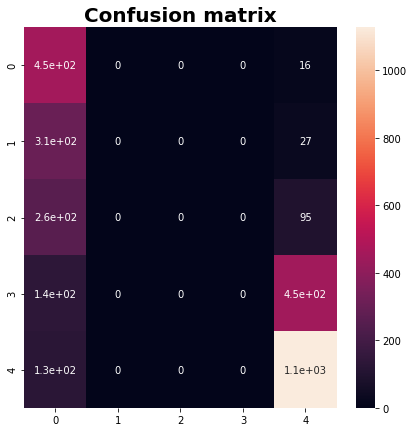

In [ ]:
evaluate_model(y_test, y_pred)

# 4. Visualize attention weights to interpret main sentences and words involved in the prediction

**Question** : add a new ```document_encoder``` method in HierarchicalAttentionNetwork model which output the document vector and attention weights (sentences weighting) from preprocessed review to determine the most importance sentences. 

**Bonus** : get word attention weights for each sentence of a review to show the important words of important sentences.

In [ ]:
from tensorflow.keras import regularizers
class HAN_new(tf.keras.Model):
    """Hierarchical Attention Network implementation.

    Reference :
    * Hierarchical Attention Networks for Document Classification : https://www.cs.cmu.edu/~./hovy/papers/16HLT-hierarchical-attention-networks.pdf

    """
    def __init__(self, vocab_size, embedding_dim, gru_units, attention_units, classifier_units, pretrained_weights=None):
        """Hierarchical Attention Network class constructor.

        """
        super(HAN_new, self).__init__()
        
        if pretrained_weights is not None:
            initializer = tf.keras.initializers.Constant(pretrained_weights)
        else:
            initializer = "uniform"

        self.embedding = tf.keras.layers.Embedding(
            vocab_size, 
            embedding_dim, 
            embeddings_initializer=initializer,
            trainable=True
        )
        self.WordGRU = tf.keras.layers.Bidirectional(
            tf.keras.layers.GRU(
                units=gru_units,
                activation="tanh",
                dropout=0.4,    ###Recurrent dropout
                kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),  ##regularization
                return_sequences=True
            ), 
            merge_mode='concat',
        )
        self.WordAttention = Attention(units=attention_units)
        self.SentenceGRU = tf.keras.layers.Bidirectional(
            tf.keras.layers.GRU(
                units=gru_units,
                activation="tanh",
                kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),  ##regularization
                dropout=0.4,    ###Recurrent dropout
                return_sequences=True
            ), 
            merge_mode='concat',
        )
        self.SentenceAttention = Attention(units=attention_units)
        self.fc = tf.keras.layers.Dense(units=classifier_units,kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),)##regularization
        self.dropout= tf.keras.layers.Dropout(rate=0.4)     ###Dropout layer

    def call(self, x):
        """Model forward method.
        """
        sentences_vectors, _ = self.word_to_sentence_encoder(x)
        document_vector, _ = self.sentence_to_document_encoder(sentences_vectors)
        return self.fc(document_vector)

    def word_to_sentence_encoder(self, x):
        """Given words from each sentences, 
           encode the contextual representation of the words from the sentence
           with Bidirectional GRU and Attention, and output a sentence_vector
        """
        x = self.embedding(x)
        x = tf.keras.layers.TimeDistributed(self.WordGRU)(x)
        x = self.dropout(x)   ###Dropout layer
        context_vector, attention_weights = self.WordAttention(x)

        return context_vector, attention_weights
    
    def document_encoder(self, sentences_vectors):
        sentences_vectors = self.SentenceGRU(sentences_vectors)
        sentences_vectors = self.dropout(sentences_vectors)   ###Dropout layer
        document_vector, attention_weights = self.SentenceAttention(sentences_vectors)
        
        return document_vector, attention_weights


In [ ]:
han_model_new = HAN_new(
    vocab_size=max(tokenizer.index_word.keys())+1, 
    embedding_dim=128, 
    pretrained_weights=pretrained_weights, 
    gru_units=32, 
    attention_units=32, 
    classifier_units=5
)

In [ ]:
sentences_vectors, word_wt = han_model_new.word_to_sentence_encoder(X_train[:1000])

In [ ]:
document_vector, sentence_wt = han_model_new.document_encoder(sentences_vectors)

In [ ]:
sentences_vectors.shape

TensorShape([1000, 10, 64])

In [ ]:
word_wt.shape

TensorShape([1000, 10, 50, 1])

In [ ]:
document_vector.shape

TensorShape([1000, 64])

In [ ]:
sentence_wt.shape

TensorShape([1000, 10, 1])

In [ ]:
X_train.shape

(7000, 10, 50)

In [ ]:
sents = [tokenizer.sequences_to_texts(x) for x in X_train]

In [ ]:
ind_sen = [x.argmax() for x in sentence_wt.numpy()]

In [ ]:
imp_sent_in_doc = [sents[i][ind_sen[i]] for i in range(1000)]
imp_sent_in_doc[:10]

['there large car park , weather nice sat outside canal , adds nice element experience .',
 'we went salad bar sorry state hardly salad , food mixed compartments , tough bread rolls sauce food place .',
 'used visit coy carp quite lot standard food and/or service extremely variable .',
 "we regulars jolly woodman new change management n't diluted character , service quality .",
 "i grew yorkshire fish chips wonderful , i 've fish chips say good .",
 'we arrived rave reviews laws given place i disappointed .',
 'we ordered dessert- one sticky toffee pudding one cookie ice cream .',
 'glad say roast dinners usual high expected standard customer care also first rate .',
 "suggested would worth dtive , arrived ignored staff eventually pointed table walkway toilets , ordered beef sunday roast rack ribs , i say food awful , rack ribs cold , bland small considering full rack ( hate see small half rack would ) 's trend serving food planks wood ?",
 'i thought outside urns water bit weird fairl

In [ ]:
ind_word = [[y.argmax() for y in s] for s in word_wt.numpy()]

In [ ]:
word_imp = [[X_train[i][j][ind_word[i][j]] for j in range(10)] for i in range(1000)]

In [ ]:
imp_words_in_sent = [tokenizer.sequences_to_texts(word_imp)]
imp_words_in_sent[:10]

[['little sat scallop place burger',
  'quick properly burger hardly potato swap incredibly also waiting men',
  'and/or i food second everyone i',
  'new needs',
  ', not',
  'i looked they i children i',
  'accidentally bar looked ( at never brought plates pudding arrived',
  ', say the',
  'hate potatoes',
  'fairly hard fairly fairly i',
  'i',
  'drink food',
  'ever nice needs chefs disaster',
  'expereince nice',
  "michael waiters/waitresses , he i '' food course pudding visit",
  'mother sat get extremely plates the shamefully',
  'potatoes flavour disgusting absolutely',
  'i they food service saucers do',
  'fresh stevie',
  'roast lovely not . food mush potatoes food none embarrassed',
  'seemed',
  'visited looking food beef',
  'curry food i love thank',
  'food warm nice pub number',
  'almost',
  'hi classic i nice ketchup seemed bland i . etc.',
  'bars tables i . place',
  'new honey warm',
  'harvester . good four',
  'heard i bar . upstairs upstairs one main little 